# Notebook Objective

In this notebook we are looking to train a machine learning model on the Anteater concrete dataset in order to predict a novel high strength formulation.

# Package Install

In [1]:
!python -m pip install -U pandas
!python -m pip install -U plotly-express
!python -m pip install xlrd
!python -m pip install -U sklearn
!python -m pip install -U nbformat
!python -m pip install -U shap
!python -m pip install ipywidgets
!python -m pip install -U dataprep
!python -m pip install -U pycaret
!python -m pip install pycaret[tuners]

  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/cf/ba/be69b6fa37c74699d333dbcbf0fc799eb31c35ce465651cdc4baf6a2e30d/pandas-2.1.0-cp310-cp310-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for numpy>=1.22.4 from https://files.pythonhosted.org/packages/d5/50/8aedb5ff1460e7c8527af15c6326115009e7c270ec705487155b779ebabb/numpy-1.25.2-cp310-cp310-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for pytz>=2020.1 from https://files.pythonhosted.org/packages/32/4d/aaf7eff5deb402fd9a24a1449a8119f00d74ae9c2efa79f8ef9994261fc2/pytz-2023.3.post1-py2.py3-none-any.whl.metadata
  Using cached tzdata-2023.3-py2.py3-none-any.whl (341 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 26.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 28.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.5/502.5 kB 15.8 MB/s eta 0:00:00
  Using cached plotly_express-0.4

# Import Libraries

In [11]:
import numpy as np
import pandas as pd
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import shap
from dataprep.eda import create_report
import pycaret
from pycaret import *
from pycaret.regression import *
import optuna

# Initial Data Exploration

## Import Dataset

The first order of business is to import our data and get an initial look at it. We are going to use the DataPrep package to save ourselves time with EDA.

In [2]:
# import data
concrete_df = pd.read_excel('Concrete_Data.xls')
concrete_df

Cement  Blast Furnace Slag  Fly Ash  Water  Superplasticizer  \
0      540.0                 0.0      0.0  162.0               2.5   
1      540.0                 0.0      0.0  162.0               2.5   
2      332.5               142.5      0.0  228.0               0.0   
3      332.5               142.5      0.0  228.0               0.0   
4      198.6               132.4      0.0  192.0               0.0   
...      ...                 ...      ...    ...               ...   
1025   276.4               116.0     90.3  179.6               8.9   
1026   322.2                 0.0    115.6  196.0              10.4   
1027   148.5               139.4    108.6  192.7               6.1   
1028   159.1               186.7      0.0  175.6              11.3   
1029   260.9               100.5     78.3  200.6               8.6   

      Coarse Aggregate  Fine Aggregate  Age  Compressive Strength  
0               1040.0           676.0   28             79.986111  
1               1055.0           676.0   28             61.887366  
2                932.0           594.0  270             40.269535  
3                932.0           594.0  365             41.052780  
4                978.4           825.5  360             44.296075  
...                ...             ...  ...                   ...  
1025             870.1           768.3   28             44.284354  
1026             817.9           813.4   28             31.178794  
1027             892.4           780.0   28             23.696601  
1028             989.6           788.9   28             32.768036  
1029             864.5           761.5   28             32.401235  

[1030 rows x 9 columns]

## Data Exploration

  0%|          | 0/1784 [00:00<?, ?it/s]

Initial EDA
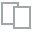
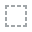
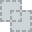
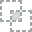
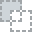
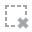
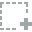
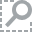
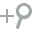
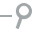
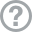
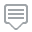
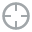
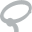
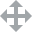
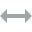
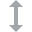
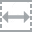
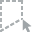
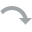
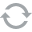
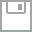
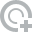
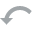
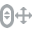
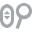
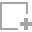
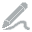
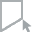
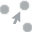
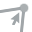
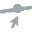

In [4]:
# initial exploratory data analysis using DataPrep package
EDA_report = create_report(concrete_df, title='Initial EDA')
EDA_report

Removing all other correlations besides the row for compressive strength from the heatmap will make it easier to see what the features stand out at first glance.

In [3]:
# create single row correlation heatmap
corr = concrete_df.corr()
print([corr['Compressive Strength'].name])
print(corr['Compressive Strength'].index.values)
print(corr["Compressive Strength"].values)
trace = go.Heatmap(z=corr['Compressive Strength'].values,
                  x=corr['Compressive Strength'].index.values,
                  y=[corr['Compressive Strength'].name] * 8,
                  text=corr['Compressive Strength'].values.round(4),
                  texttemplate="%{text}")

comp_strength_heatmap = go.Figure()
comp_strength_heatmap.add_trace(trace)
comp_strength_heatmap.show()

['Compressive Strength']
['Cement' 'Blast Furnace Slag' 'Fly Ash' 'Water' 'Superplasticizer'
 'Coarse Aggregate' 'Fine Aggregate' 'Age' 'Compressive Strength']
[ 0.49783272  0.13482445 -0.10575335 -0.28961348  0.3661023  -0.16492782
 -0.16724896  0.32887698  1.        ]


Having a high cement content, low water, some superplasticizer, and some aging is suggested to be important for high strength formulations.

Sorting the dataframe by compressive strength and comparing the formulations to the general distributions will enable us to confirm.

In [4]:
# sort initial dataframe by target variable (compressive strength)
concrete_df_sorted = concrete_df.sort_values(by='Compressive Strength', ascending=False)
concrete_df_sorted.head(10)

Cement  Blast Furnace Slag  Fly Ash  Water  Superplasticizer  \
181   389.9               189.0      0.0  145.9             22.00   
381   315.0               137.0      0.0  145.0              5.90   
153   323.7               282.8      0.0  183.8             10.30   
0     540.0                 0.0      0.0  162.0              2.50   
159   389.9               189.0      0.0  145.9             22.00   
182   362.6               189.0      0.0  164.9             11.60   
175   362.6               189.0      0.0  164.9             11.60   
177   362.6               189.0      0.0  164.9             11.60   
179   362.6               189.0      0.0  164.9             11.60   
383   451.0                 0.0      0.0  165.0             11.25   

     Coarse Aggregate  Fine Aggregate  Age  Compressive Strength  
181             944.7           755.8   91             82.599225  
381            1130.0           745.0   28             81.751169  
153             942.7           659.9   56             80.199848  
0              1040.0           676.0   28             79.986111  
159             944.7           755.8   56             79.400056  
182             944.7           755.8   91             79.296635  
175             944.7           755.8   91             79.296635  
177             944.7           755.8   91             79.296635  
179             944.7           755.8   91             79.296635  
383            1030.0           745.0   28             78.800212

In [5]:
top_10_comp_strength = concrete_df_sorted.head(10)

In [6]:
concrete_df_sorted.describe()

Cement  Blast Furnace Slag      Fly Ash        Water  \
count  1030.000000         1030.000000  1030.000000  1030.000000   
mean    281.165631           73.895485    54.187136   181.566359   
std     104.507142           86.279104    63.996469    21.355567   
min     102.000000            0.000000     0.000000   121.750000   
25%     192.375000            0.000000     0.000000   164.900000   
50%     272.900000           22.000000     0.000000   185.000000   
75%     350.000000          142.950000   118.270000   192.000000   
max     540.000000          359.400000   200.100000   247.000000   

       Superplasticizer  Coarse Aggregate  Fine Aggregate          Age  \
count       1030.000000       1030.000000     1030.000000  1030.000000   
mean           6.203112        972.918592      773.578883    45.662136   
std            5.973492         77.753818       80.175427    63.169912   
min            0.000000        801.000000      594.000000     1.000000   
25%            0.000000        932.000000      730.950000     7.000000   
50%            6.350000        968.000000      779.510000    28.000000   
75%           10.160000       1029.400000      824.000000    56.000000   
max           32.200000       1145.000000      992.600000   365.000000   

       Compressive Strength  
count           1030.000000  
mean              35.817836  
std               16.705679  
min                2.331808  
25%               23.707115  
50%               34.442774  
75%               46.136287  
max               82.599225

In [7]:
top_10_box_fig = px.strip(top_10_comp_strength, y=["Cement", "Water", "Superplasticizer", "Age"], stripmode='overlay')
top_10_box_fig.add_trace(go.Box(y=concrete_df['Cement'], name='Cement'))
top_10_box_fig.add_trace(go.Box(y=concrete_df['Water'], name='Water'))
top_10_box_fig.add_trace(go.Box(y=concrete_df['Superplasticizer'], name='Superplasticizer'))
top_10_box_fig.add_trace(go.Box(y=concrete_df['Age'], name='Age'))

top_10_box_fig.update_layout(
    title='Top 10 Compressive Samples with Distribuitions',
    xaxis_title="Feature",
    autosize=False,
    width=1300,
    height=700
)

top_10_box_fig.show()

Our initial hypothesis based on the correlation heatmap was reasonably correct. The top ten formulations by compressive strength generally had high cement content (60% were above the 75th percentile), low water (90% were <=25th percentile), contained superplasticizer (100%), and well aged (70% >= 75th percentile). We will keep this in mind when we evaluate our model's predictions.

## Data Cleanup

DataPrep shows that there are duplicate rows. We will investigate and ensure they are actually duplicates.

In [8]:
# check that the duplicates are real
concrete_df[concrete_df.duplicated(keep=False)]

Cement  Blast Furnace Slag  Fly Ash  Water  Superplasticizer  \
72    425.0               106.3      0.0  153.5              16.5   
77    425.0               106.3      0.0  153.5              16.5   
80    425.0               106.3      0.0  153.5              16.5   
83    362.6               189.0      0.0  164.9              11.6   
86    362.6               189.0      0.0  164.9              11.6   
88    362.6               189.0      0.0  164.9              11.6   
91    362.6               189.0      0.0  164.9              11.6   
95    425.0               106.3      0.0  153.5              16.5   
100   425.0               106.3      0.0  153.5              16.5   
103   425.0               106.3      0.0  153.5              16.5   
106   362.6               189.0      0.0  164.9              11.6   
109   362.6               189.0      0.0  164.9              11.6   
111   362.6               189.0      0.0  164.9              11.6   
118   425.0               106.3      0.0  153.5              16.5   
123   425.0               106.3      0.0  153.5              16.5   
126   425.0               106.3      0.0  153.5              16.5   
129   362.6               189.0      0.0  164.9              11.6   
132   362.6               189.0      0.0  164.9              11.6   
134   362.6               189.0      0.0  164.9              11.6   
137   362.6               189.0      0.0  164.9              11.6   
141   425.0               106.3      0.0  153.5              16.5   
146   425.0               106.3      0.0  153.5              16.5   
149   425.0               106.3      0.0  153.5              16.5   
152   362.6               189.0      0.0  164.9              11.6   
155   362.6               189.0      0.0  164.9              11.6   
157   362.6               189.0      0.0  164.9              11.6   
160   362.6               189.0      0.0  164.9              11.6   
164   425.0               106.3      0.0  153.5              16.5   
169   425.0               106.3      0.0  153.5              16.5   
172   425.0               106.3      0.0  153.5              16.5   
175   362.6               189.0      0.0  164.9              11.6   
177   362.6               189.0      0.0  164.9              11.6   
179   362.6               189.0      0.0  164.9              11.6   
182   362.6               189.0      0.0  164.9              11.6   
801   252.0                 0.0      0.0  185.0               0.0   
809   252.0                 0.0      0.0  185.0               0.0   

     Coarse Aggregate  Fine Aggregate  Age  Compressive Strength  
72              852.1           887.1    3             33.398217  
77              852.1           887.1    3             33.398217  
80              852.1           887.1    3             33.398217  
83              944.7           755.8    3             35.301171  
86              944.7           755.8    3             35.301171  
88              944.7           755.8    3             35.301171  
91              944.7           755.8    3             35.301171  
95              852.1           887.1    7             49.201007  
100             852.1           887.1    7             49.201007  
103             852.1           887.1    7             49.201007  
106             944.7           755.8    7             55.895819  
109             944.7           755.8    7             55.895819  
111             944.7           755.8    7             55.895819  
118             852.1           887.1   28             60.294676  
123             852.1           887.1   28             60.294676  
126             852.1           887.1   28             60.294676  
129             944.7           755.8   28             71.298713  
132             944.7           755.8   28             71.298713  
134             944.7           755.8   28             71.298713  
137             944.7           755.8   28             71.298713  
141             852.1           887.1   56  

The duplicate rows are real and the duplicates should be removed.

In [9]:
# drop duplicates
concrete_df.drop_duplicates(inplace=True, ignore_index=True)

# check all duplicates have been removed
concrete_df[concrete_df.duplicated(keep=False)]

Empty DataFrame
Columns: [Cement, Blast Furnace Slag, Fly Ash, Water, Superplasticizer, Coarse Aggregate, Fine Aggregate, Age, Compressive Strength]
Index: []

# Modeling

## Pycaret

### Model Building and Training

Pycaret is a low code package designed to accelerate machine learning development. We will use it to train and compare the performance of various models.

In [12]:
s = setup(
          concrete_df,
          target = 'Compressive Strength',
          transformation=True,
          normalize=True,
          session_id=123
          )
best_model = compare_models()

Processing:   0%|          | 0/77 [00:00<?, ?it/s]

In [13]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Our first model has a reasonably good error. Tuning the hyperparameters might provide additional benefit.

In [14]:
# Tune hyperparameters
best_model = tune_model(best_model, optimize='RMSE', search_library='optuna')

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

[I 2023-09-05 14:15:12,569] Searching the best hyperparameters using 703 samples...


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.49162995337209514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49162995337209514
[LightGBM] [Warning] bagging_fraction is set=0.5802194368776818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5802194368776818
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.49162995337209514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49162995337209514
[LightGBM] [Warning] bagging_fraction is set=0.5802194368776818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5802194368776818
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000332 

[I 2023-09-05 14:15:57,824] Finished hyperparameter search!


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5192970038251772, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5192970038251772
[LightGBM] [Warning] bagging_fraction is set=0.8673201312269808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8673201312269808


Tuning provided a small benefit. We will now finalize the model on the entire dataset and make predictions.

In [15]:
# train best model on entire dataset
best_model_final = finalize_model(best_model)

### Shapley Values

It will be interesting to see the feature importance plots. We will use the Shap function of Pycaret to see if the features we thought were important originally are the same in the model.

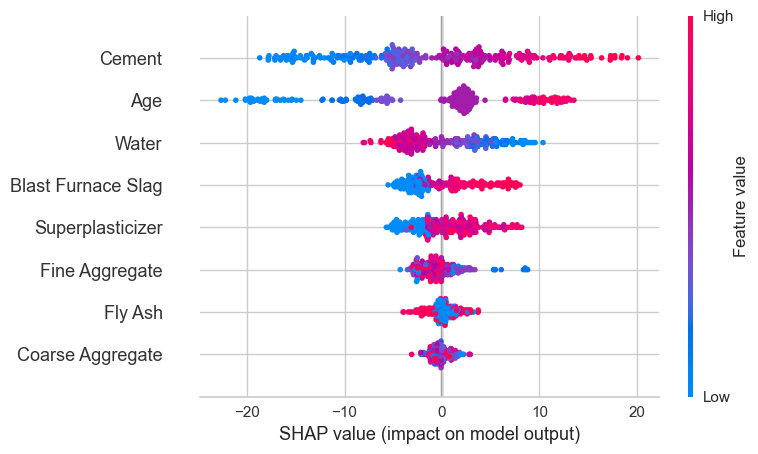

In [24]:
# calculate Shapley values for LightGBM model
X_test = get_config(variable="X_test_transformed")
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# create summary plot of SHAP values for features ordered by importance
shap.summary_plot(shap_values, X_test)

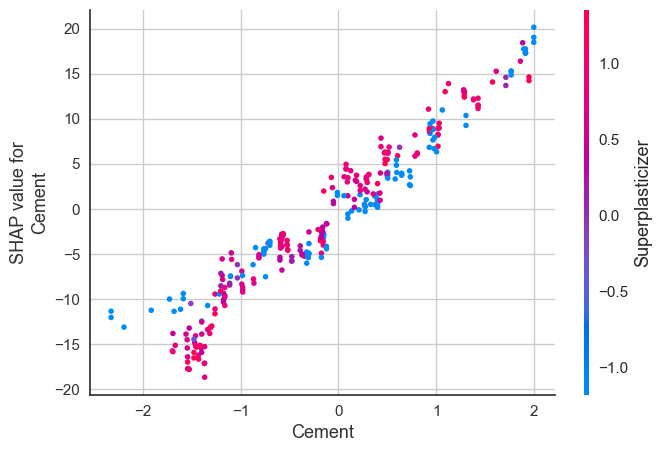

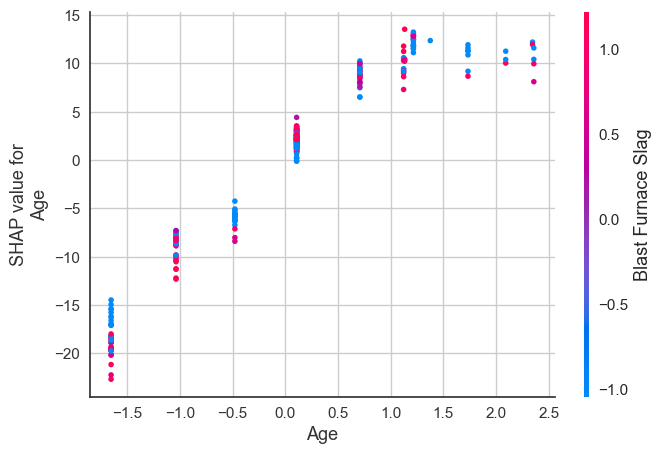

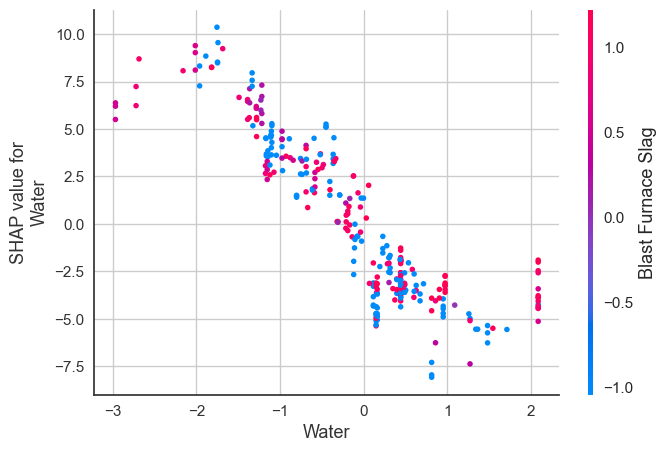

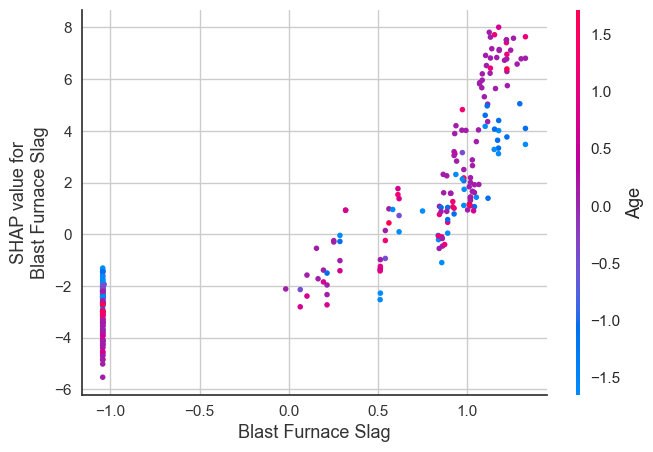

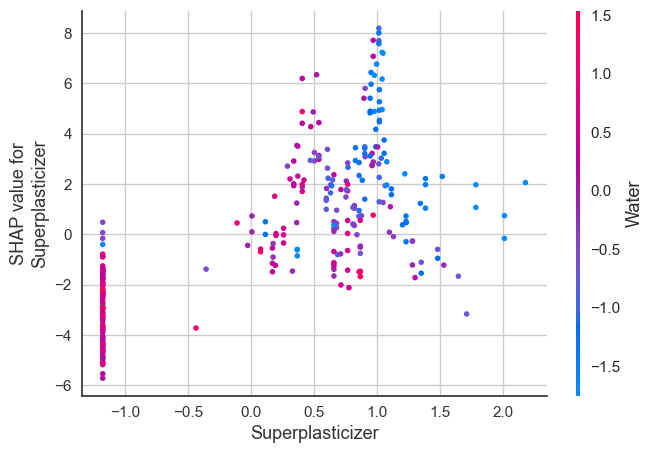

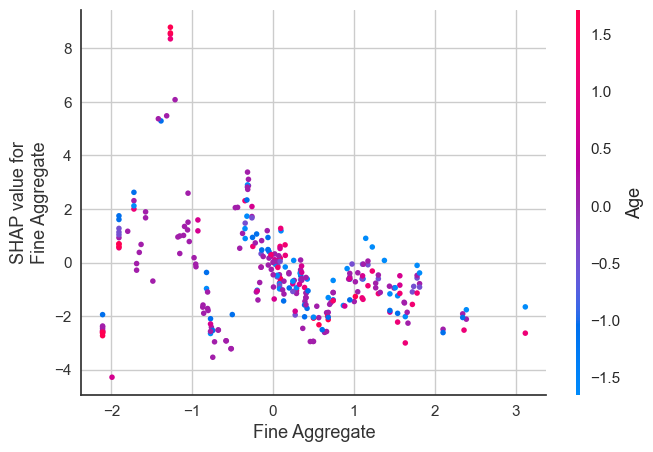

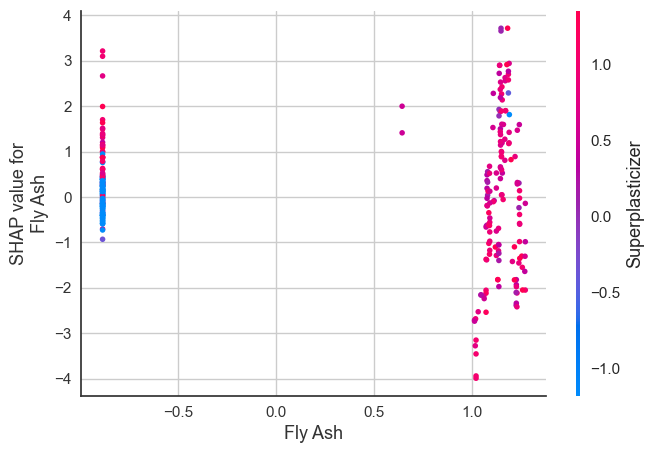

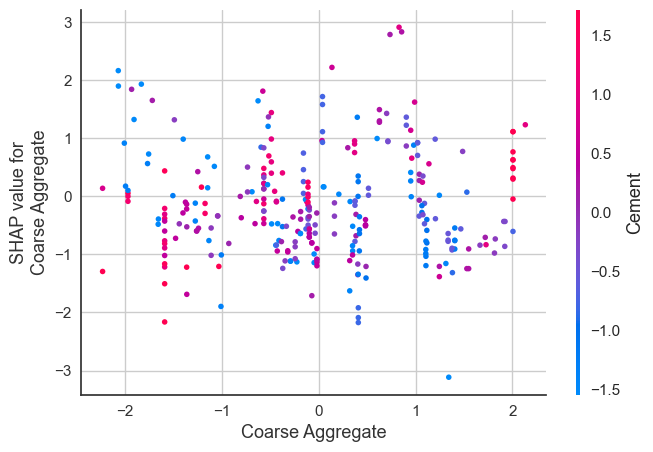

In [25]:
# sort the features indexes by their importance in the model
# (sum of SHAP value magnitudes over the validation dataset)
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

# make SHAP plots of the most important features
for i in range(8):
    shap.dependence_plot(top_inds[i], shap_values, X_test)

The SHAP plots give a good indication that our trained model agrees our initial hypothesis on feature importance. 

Notes:

1. Age - Seems to peak in importance before plateauing, suggesting high amounts of aging might not improve strength
2. Cement - Generally the more the merrier
3. Water - The less the better
4. Superplasticizer - Hard to tell if the more the merrier or if there is a plateau of any kind

# Novel Formulation Prediction

We will generator a random set of formulations and predict on the dataset. These formulations will use the density of water as an assumption in order to generate valid formulations.

In [35]:
import numpy as np

def get_random_numbers(nrows=100000000, ncols=8):
    # Generate a matrix of random integers between 0 and 100
    mat = np.random.randint(0, 100, size=(nrows, ncols), dtype='uint8')
    
    # Divide each element in the matrix by the sum of its row
    normed_mat = mat / np.sum(mat, axis=1, keepdims=True) * 1000
    
    return normed_mat

result = get_random_numbers()
result

array([[168.12227074, 163.75545852, 109.17030568, ..., 117.90393013,
        139.73799127, 159.38864629],
       [123.82739212, 129.45590994,  90.05628518, ..., 108.81801126,
        183.86491557, 157.59849906],
       [268.01152738, 138.32853026,  97.98270893, ..., 172.91066282,
         74.92795389, 161.3832853 ],
       ...,
       [  2.88184438,  46.10951009,  83.57348703, ..., 236.31123919,
        221.90201729, 227.66570605],
       [ 94.98680739, 158.31134565, 229.55145119, ...,  15.83113456,
        113.45646438, 237.46701847],
       [108.35214447, 144.46952596,  11.28668172, ..., 135.44018059,
         47.40406321, 173.81489842]])

In [36]:
novel_df = pd.DataFrame(data=result, columns=["Cement", "Blast Furnace Slag", "Fly Ash", "Water", "Superplasticizer", "Coarse Aggregate", "Fine Aggregate", "Age"])
novel_df = novel_df[novel_df['Superplasticizer'] < 50]
novel_df

Cement  Blast Furnace Slag     Fly Ash       Water  \
0         168.122271          163.755459  109.170306  133.187773   
1         123.827392          129.455910   90.056285  172.607880   
2         268.011527          138.328530   97.982709   37.463977   
4          85.766423          129.562044  156.934307  167.883212   
9         195.294118          162.352941  164.705882  183.529412   
...              ...                 ...         ...         ...   
99999961   41.769042          211.302211  157.248157  127.764128   
99999964  101.886792          135.849057  181.132075  154.716981   
99999972  175.342466          208.219178  224.657534   32.876712   
99999979  122.194514            2.493766   42.394015  226.932668   
99999984  127.478754          158.640227   14.164306  155.807365   

          Superplasticizer  Coarse Aggregate  Fine Aggregate         Age  
0                 8.733624        117.903930      139.737991  159.388646  
1                33.771107        108.818011      183.864916  157.598499  
2                48.991354        172.910663       74.927954  161.383285  
4                34.671533        177.007299      156.934307   91.240876  
9                25.882353         94.117647      145.882353   28.235294  
...                    ...               ...             ...         ...  
99999961         19.656020        179.361179      167.076167   95.823096  
99999964         11.320755        286.792453      116.981132   11.320755  
99999972         49.315068         21.917808       65.753425  221.917808  
99999979         17.456359        192.019950      167.082294  229.426434  
99999984         16.997167         82.152975      215.297450  229.461756  

[18718171 rows x 8 columns]

In [37]:
predictions_df = predict_model(best_model_final, data = novel_df)

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.49162995337209514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49162995337209514
[LightGBM] [Warning] bagging_fraction is set=0.5802194368776818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5802194368776818


In [38]:
predictions_df.head()

Cement  Blast Furnace Slag     Fly Ash       Water  Superplasticizer  \
0  168.122269          163.755463  109.170303  133.187775          8.733624   
1  123.827393          129.455917   90.056282  172.607880         33.771107   
2  268.011536          138.328537   97.982712   37.463978         48.991356   
4   85.766426          129.562042  156.934311  167.883209         34.671532   
9  195.294113          162.352936  164.705887  183.529419         25.882353   

   Coarse Aggregate  Fine Aggregate         Age  prediction_label  
0        117.903931      139.737991  159.388641         52.649688  
1        108.818008      183.864914  157.598495         43.877596  
2        172.910660       74.927956  161.383286         53.993256  
4        177.007294      156.934311   91.240875         44.612906  
9         94.117645      145.882355   28.235294         25.663781

In [39]:
# top 10 predictions
predictions_df.nlargest(10, 'prediction_label')

Cement  Blast Furnace Slag     Fly Ash       Water  \
25385244  323.529419          180.147064  143.382355  147.058823   
95394609  316.293915          172.523956  130.990417  150.159744   
55660051  326.599335          188.552185    6.734007  148.148148   
21541266  316.062164          186.528503   15.544042  124.352333   
89569514  321.839081          298.850586   34.482758    0.000000   
12068254  316.498322          178.451172   23.569023  138.047134   
1756466   276.923065          178.461533  141.538467  150.769226   
13119405  321.917816          181.506851    3.424658   17.123287   
5132787   328.719727          169.550171   13.840831  148.788925   
69273522  320.422546          176.056335  193.661972  144.366196   

          Superplasticizer  Coarse Aggregate  Fine Aggregate         Age  \
25385244         47.794117         55.147060       11.029411   91.911766   
95394609          6.389776        118.210861        6.389776   99.041534   
55660051          6.734007         50.505051       50.505051  222.222229   
21541266         10.362695         46.632126       31.088083  269.430054   
89569514         11.494253         19.157087       42.145596  272.030640   
12068254          6.734007         20.202021       94.276093  222.222229   
1756466          12.307693          3.076923       12.307693  224.615387   
13119405         10.273973        143.835617       65.068497  256.849304   
5132787           6.920415         58.823528      141.868515  131.487885   
69273522         17.605635         17.605635       24.647888  105.633804   

          prediction_label  
25385244         74.373091  
95394609         74.260043  
55660051         73.877013  
21541266         73.795827  
89569514         73.716132  
12068254         73.502701  
1756466          73.340255  
13119405         73.290008  
5132787          73.232967  
69273522         73.164218

In [34]:
# strip plot of random formulations
novel_formulation_fig = px.strip(y=predictions_df['prediction_label'], title="Predicted Compressive Strength", 
                                 labels={'y': "Predicted Compressive Strength (MPa)"})
novel_formulation_fig.show()

It appears that we have some formulations that are worth trying, but even with a huge amount of random samples we don't predict any formulations that are higher in strength than the current set of formulations. This may be due to the error introduced by assuming everything is the density of water, so that is an area ripe for improvement. 

# Next Steps

Good next steps would include

1. Adding error metrics to individual predictions.
2. Investigating additional models.
3. Getting more data.